In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
from math import pi
from astropy.time import Time

import warnings
warnings.filterwarnings(action='once')
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 600)

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.2

In [2]:
def gsmooth(x_array, y_array, var_y, vexp , nsig = 5.0):
    """Function gsmooth() is an inverse variance weighted Gaussian smoothing of spectra
       Optional imputs are smoothing velocity (vexp) and number of sigma (nsig)
       Syntax: new_y_array = gsmooth(x_array, y_array, var_y, vexp = 0.01, nsig = 5.0)
    """
    
    # Check for zero variance points, and set to 1E-20

    if var_y is None:
        var_y = 1.e-31*np.ones(len(y_array))
    
    # Output y-array
    new_y = np.zeros(len(x_array), float)
    
    # Loop over y-array elements
    for i in range(len(x_array)):
        
        # Construct a Gaussian of sigma = vexp*x_array[i]
        gaussian = np.zeros(len(x_array), float)
        sigma = vexp*x_array[i]
        
        # Restrict range to +/- nsig sigma
        sigrange = np.nonzero(abs(x_array-x_array[i]) <= nsig*sigma)
        gaussian[sigrange] = (1/(sigma*np.sqrt(2*pi)))*np.exp(-0.5*((x_array[sigrange]-x_array[i])/sigma)**2)
        
        # Multiply Gaussian by 1 / variance
        W_lambda = gaussian / var_y
        
        # Perform a weighted sum to give smoothed y value at x_array[i]
        W0 = np.sum(W_lambda)
        W1 = np.sum(W_lambda*y_array)
        new_y[i] = W1/W0

    # Return smoothed y-array
    return new_y

def find_vexp(x_array, y_array, var_y=None):
    """ Determines the optimal smoothing parameter (vexp) based on an estimate of SNR
    """
    if var_y is not None:
        error = np.sqrt(var_y)
        new_y_init = gsmooth(x_array, y_array, var_y, .002)
        SNR = np.median(new_y_init / error)
    else:
        new_y_init = gsmooth(x_array, y_array, var_y, .002) #this smoothing should get in right ballpark
        error = np.absolute(y_array - new_y_init)
        sm_error = gsmooth(x_array, error, var_y, .008)
        SNR = np.median(new_y_init / sm_error)

    #TODO: interpolate a function of SNR
    # vexp_line = np.polyfit([2.5, 80], [.0045, .001], 1)
    # coeff_0 = vexp_line[0]
    # coeff_1 = vexp_line[1]
    # results from above:
    coeff_0 = -4.51612903e-05
    coeff_1 = 4.61290323e-03
    vexp_auto = coeff_0*SNR + coeff_1

    if SNR < 2.5:
        vexp_auto = .0045
    if SNR > 80:
        vexp_auto = .001

    return vexp_auto, SNR

In [3]:
import re
from astropy.time import Time
rootdir = 'data/spectra/FoundationSpec/'
i = 0.0
names = []
fluxes = []
waves = []
phases = []
norms = []

no_shift = ['asassn15bm']
manual_norm = {'atlas16bdg':0.6}
for subdir, dirs, files in os.walk(rootdir):
    for fl in files:
        if ('.DS_Store' not in fl):
            spec = pd.read_csv(rootdir+fl, delim_whitespace=True, comment='#', names=['wave','flux'])
            with open(rootdir+fl, 'r') as f:
                all_data = [line.strip('#\t').strip() for line in f.readlines()]
                head = all_data[:8]
            name = head[0]
            for entry in head:
                if 'UT date of observation' in entry:
                    date_obs = str(entry.split(':')[1]).strip()
                    d = Time('{}-{}-{}'.format(date_obs[0:4],date_obs[4:6],date_obs[6:]), format='iso')
                    mjd_obs = d.mjd 
                elif 'Estimated Peak MJD' in entry:
                    mjd_peak = float(entry.split(':')[1])
                elif 'Estimated redshift' in entry:
                    z = float(entry.split(':')[1])
            phase = mjd_obs - mjd_peak
            
            if name not in no_shift:
                spec['wave'] = spec['wave'] / (1.0 + z)
            spec = spec[(spec['wave'] > 4200) & (spec['wave'] < 7000)]
            
            vexp_auto, SNR = find_vexp(spec['wave'].values,spec['flux'].values)
            flux_smooth = gsmooth(spec['wave'].values,spec['flux'].values, 
                                  None, vexp_auto)
            norm = np.median(flux_smooth)
            flux_smooth = flux_smooth/norm
            
            if ~np.isnan(phase):
                names.append(name)
                phases.append(phase)
                waves.append(spec['wave'].values)
                fluxes.append(flux_smooth)
                norms.append(norm)
                i = i+1

In [4]:
def fixName(name):
    if ('asassn-' in name):
        new_name = re.sub('asassn','ASASSN',name)
    elif ('asassn' in name):
        new_name = re.sub('asassn','ASASSN-',name)
    elif ('ps1' in name):
        new_name = re.sub('ps','PS',name)
    elif ('atlas' in name):
        new_name = re.sub('atlas','ATLAS',name)
    elif ('psnj' in name):
        new_name = re.sub('psnj','PSNJ',name)
    elif ('gaia' in name):
        new_name = re.sub('gaia','Gaia',name)
    elif ('ptss' in name):
        new_name = re.sub('ptss','PTSS',name)
    elif ('masterj' in name):
        new_name = re.sub('masterj','MASTERJ',name)
    elif ('master' in name):
        new_name = re.sub('master','MASTER',name)
    elif ('css' in name):
        new_name = re.sub('css','CSS',name)
    else:
        new_name = name
    return new_name

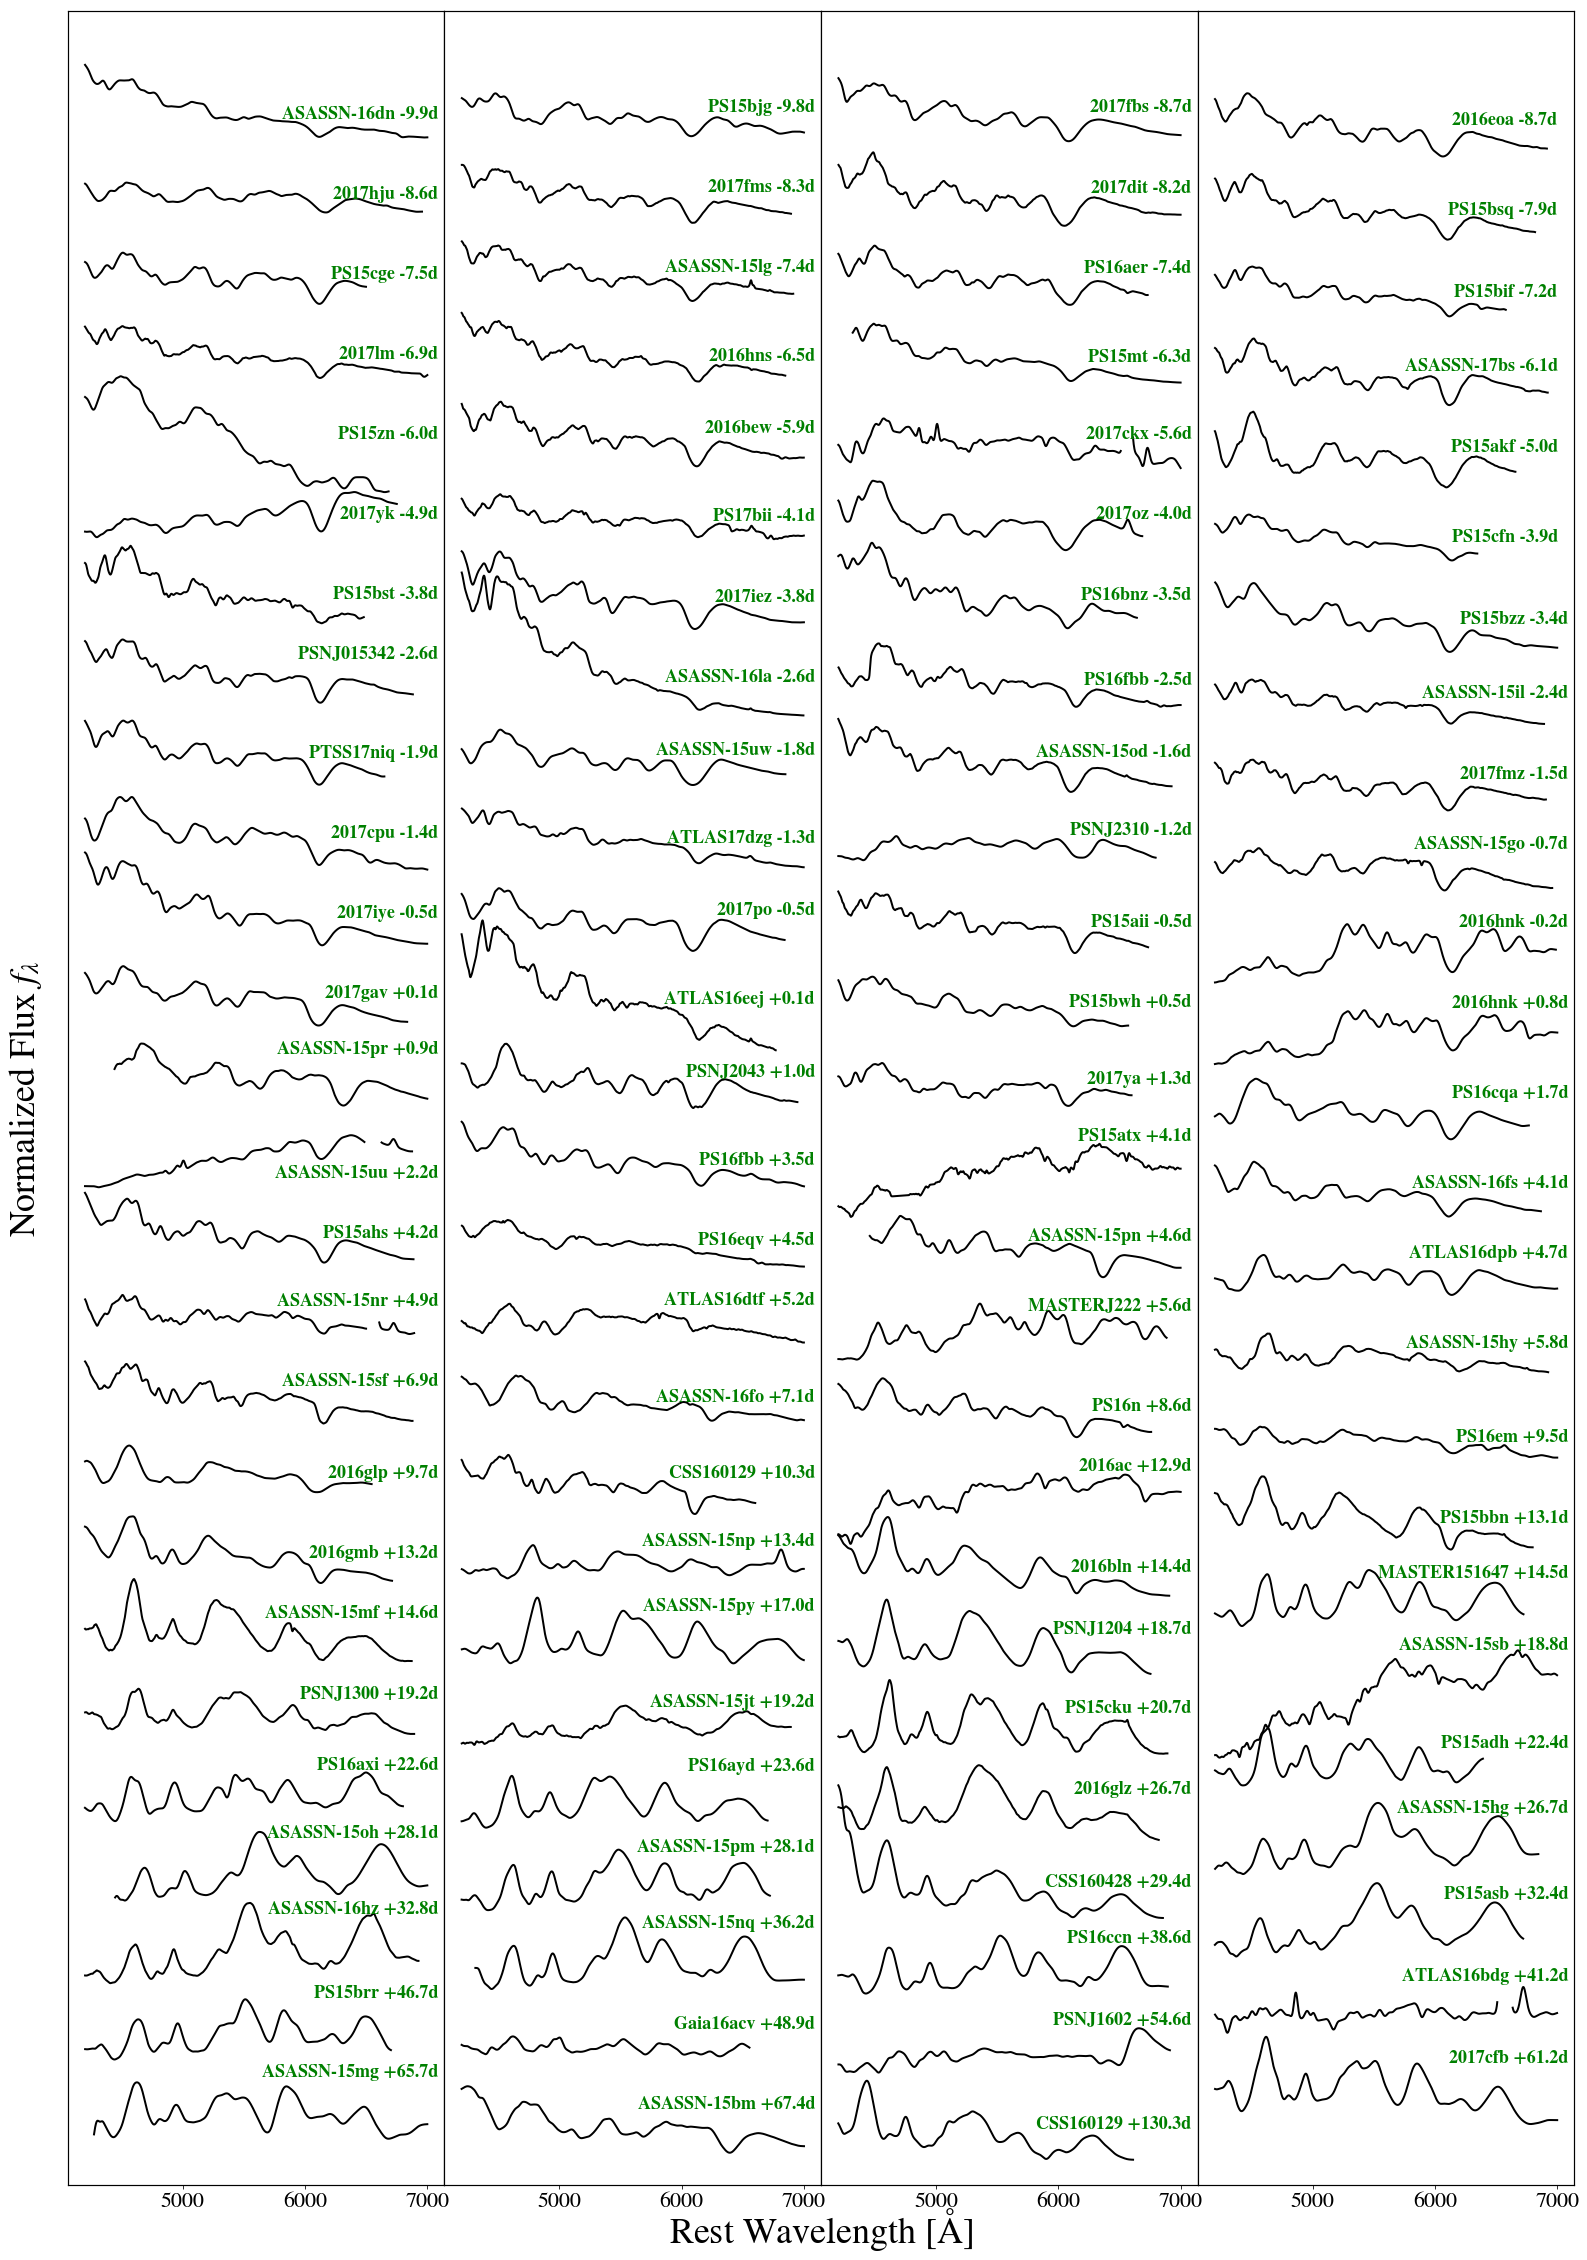

In [5]:
srt_inds = np.argsort(phases)
phases_srt = np.array(phases)[srt_inds]
names_srt = np.array(names)[srt_inds]
waves_srt = np.array(waves)[srt_inds]
fluxes_srt = np.array(fluxes)[srt_inds]
norms_srt = np.array(norms)[srt_inds]

norm_dict = {'ps15zn':3.0, '2017ckx':3.5, 'ps15bst':3.0, '2017ya':2.0, 'ps15atx':2.0,
             'asassn15nr':2.0, '2016ac':3.0, 'asassn15sb':3.0, 'atlas16bdg':4.0, 
             'atlas16eej':2.1, '2017oz':2.0, '2017cpu':2.0}
text_dict = {'ps15mt':-140, 'asassn15pn':-220, 'asassn15pr':-225, 'asassn15oh':-230, 
             'asassn15nq':-120}
hostlines_dict = {'2017ckx':[6510,6610], 'atlas16bdg':[6510,6635], 
                  'asassn15uu':[6485,6625], 'asassn15nr':[6500,6605]}
label_dict = {'asassn17bs':0.1, 'psnj015342':0.5, 'ASASSN15pr':0.6, 'asassn15uu':-0.5, 'asassn15mf':0.5,
              'psnj1300':0.5, 'ps16axi':0.7, 'ASASSN15oh':1., 'ps15brr':1., 'asassn15mg':1., 'asassn16hz':1.1, 
              'ATLAS16dtf':0.5, 'asassn15np':0.5, 'asassn15py':0.9, 'asassn15jt':0.5, 'PS16ayd':0.9,
              'asassn15pm':0.9, 'ASASSN15nq':1., 'gaia16acv':0.5, 'masterj222':0.5, '2016ac':0.5, 
              'psnj1204':0.5, 'ps15cku':0.5, '2016glz':0.5, 'ps16ccn':0.7, 'psnj1602':0.8, 'asassn15bm':0.5,
              'asassn15go':0.5, '2016hnk':0.6, 'ps15atx':0.5, 'ATLAS16dpb':0.5, 'master151647':0.65, 
              'asassn15sb':0.9, 'ps15adh':0.5, 'asassn15hg':0.9, 'atlas16bdg':0.8, '2017cfb':0.8, 
              'asassn15uw':0.2, 'psnj2043':0.2, 'asassn16fo':0.1, 'css160129':0.2, 'ps15asb':0.8, 
              'asassn15hy':0.3, 'psnj2310':0.1, '2017oz':0.1, 'ps15akf':0.1, 'ASASSN15pn':0.2, 'asassn15nr':0.3,
              'asassn15sf':0.3, 'PS15bjg':0.2, '2017fms':0.2, 'asassn15lg':0.2, '2016bew':0.2, '2017po':0.2,
              '2017fbs':0.2, '2017dit':0.2, 'ps16aer':0.2, '2017ckx':0.1, '2017oz':0.1, 'ps16bnz':0.1, 
              'asassn15od':0.2, 'psnj2310':0.3, '2017ya':0.1, 'ps15atx':0.7, 'css160428':0.2, 'ps16ccn':0.8, 
              '2016eoa':0.2, 'asassn17bs':0.2, 'ps15akf':0.2, 'asassn15il':0.2, '2017fmz':0.2, 'ps16cqa':0.4, 
              'asassn16fs':0.2, 'ps16em':0.2}

fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(27,40))
plt.subplots_adjust(wspace=0.0)
for i in range(len(names_srt)):
    if names_srt[i] == 'ASASSN5mg':
        continue
    if names_srt[i] in norm_dict.keys():
        norm = norm_dict[names_srt[i]]
    else:
        norm = 1.0
    if names_srt[i] in text_dict.keys():
        shift = text_dict[names_srt[i]]
    else:
        shift = 0
    if names_srt[i] in hostlines_dict.keys():
        fluxes_srt[i][(waves_srt[i] > hostlines_dict[names_srt[i]][0]) & 
                      (waves_srt[i] < hostlines_dict[names_srt[i]][1])] = np.nan
    if names_srt[i] in label_dict.keys():
        label_shift = label_dict[names_srt[i]]
    else:
        label_shift = 0.0


    if i%4 == 0.0:
        ax1.plot(waves_srt[i], (fluxes_srt[i]*norm)-i*0.5-norm, color='black')
        ax1.text(ax1.get_xlim()[-1]-50, -i*0.5+label_shift, 
                 '{} {:+.1f}d'.format(fixName(names_srt[i].lower()),phases_srt[i]),
                 fontdict={'weight':'bold','size':12},horizontalalignment='right',color='green',fontsize=18)
    elif i%4 == 1.0:
        ax2.plot(waves_srt[i], (fluxes_srt[i]*norm)-i*0.5-norm, color='black')
        ax2.text(ax2.get_xlim()[-1]-50, -i*0.5+label_shift, 
                 '{} {:+.1f}d'.format(fixName(names_srt[i].lower()),phases_srt[i]),
                 fontdict={'weight':'bold','size':12},horizontalalignment='right',color='green',fontsize=18)
    elif i%4 == 2.0:
        ax3.plot(waves_srt[i], (fluxes_srt[i]*norm)-i*0.5-norm, color='black')
        ax3.text(ax3.get_xlim()[-1]-50, -i*0.5+label_shift, 
                 '{} {:+.1f}d'.format(fixName(names_srt[i].lower()),phases_srt[i]),
                 fontdict={'weight':'bold','size':12},horizontalalignment='right',color='green',fontsize=18)
    elif i%4 == 3.0:
        ax4.plot(waves_srt[i], (fluxes_srt[i]*norm)-i*0.5-norm, color='black')
        ax4.text(ax4.get_xlim()[-1]-50, -i*0.5+label_shift, 
                 '{} {:+.1f}d'.format(fixName(names_srt[i].lower()),phases_srt[i]),
                 fontdict={'weight':'bold','size':12},horizontalalignment='right',color='green',fontsize=18)
            
ax1.tick_params(labelsize=22)
ax2.tick_params(labelsize=22)
ax3.tick_params(labelsize=22)
ax4.tick_params(labelsize=22)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Rest Wavelength [$\mathrm{\AA}$]', fontsize=36)
plt.ylabel(r'Normalized Flux $f_{\lambda}$', fontsize=36)
ax1.set_ylim(-51.7,2.7)
ax2.set_ylim(-51.9,2.2)
ax3.set_ylim(-52.2,1.7)
ax4.set_ylim(-51.7,1.5)

plt.savefig('collateSpectra_figures/foundationSpectra.pdf',bbox_inches='tight')
plt.savefig('collateSpectra_figures/foundationSpectra.png',bbox_inches='tight')

In [6]:
with open('tables/obstable.tex','w') as fout:
    for subdir, dirs, files in os.walk(rootdir):
        for fl in files:
            if ('.DS_Store' not in fl):
                spec = pd.read_csv(rootdir+fl, delim_whitespace=True, comment='#', names=['wave','flux'])
                minwave = int(np.nanmin(spec['wave']))
                maxwave = int(np.nanmax(spec['wave']))
                with open(rootdir+fl, 'r') as f:
                    all_data = [line.strip('#\t').strip() for line in f.readlines()]
                    head = all_data[:8]
                name = fixName(head[0])
                for entry in head:
                    if 'UT date of observation' in entry:
                        date_obs = str(entry.split(':')[1]).strip()
                        d = Time('{}-{}-{}'.format(date_obs[0:4],date_obs[4:6],date_obs[6:]), format='iso')
                        mjd_obs = d.mjd
                    elif 'Estimated Peak MJD' in entry:
                        mjd_peak = float(entry.split(':')[1])
                    elif 'Estimated redshift' in entry:
                        z = float(entry.split(':')[1])
                    elif 'Telescope/Instrument' in entry:
                        inst = entry.split(':')[1]
                phase = (mjd_obs - mjd_peak) / (1.+z)
                
                if np.isnan(phase):
                    phase = r'\nodata'
                    mjd_peak = r'\nodata'

                    fout.write('{} & {} & ${:.3f}$ & {}-{}-{} & {} & {} & {}-{} \\\\ \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))
                    print('{} & {} & {:.3f} & {}-{}-{} & {} & {} & {}-{} \\\\ \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))
                else:
                    fout.write('{} & {} & ${:.3f}$ & {}-{}-{} & ${:.1f}$ & ${:.1f}$ & {}-{} \\\\ \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))
                    print('{} & {} & {:.3f} & {}-{}-{} & {:.1f} & {:.1f} & {}-{} \\\\ \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))

2016ac &  FLWO1.5m/FAST & 0.026 & 2016-02-04 & 57409.1 & 12.6 & 3463-7403 \\ 

2016bew &  SALT/RSS & 0.054 & 2016-03-14 & 57466.9 & -5.6 & 3348-9250 \\ 

2016bln &  KPNO4m/KOSMOS & 0.023 & 2016-05-06 & 57499.6 & 14.1 & 4165-7065 \\ 

2016eoa &  KPNO4m/KOSMOS & 0.021 & 2016-08-07 & 57615.7 & -8.5 & 4180-7060 \\ 

2016glp &  SOAR/Goodman & 0.085 & 2016-10-08 & 57659.3 & 8.9 & 3700-7100 \\ 

2016glz &  SOAR/Goodman & 0.041 & 2016-10-30 & 57664.3 & 25.6 & 3600-7100 \\ 

2016gmb &  SOAR/Goodman & 0.058 & 2016-10-08 & 57655.8 & 12.5 & 3700-7100 \\ 

2016hnk &  SOAR/Goodman & 0.016 & 2016-10-30 & 57691.2 & -0.2 & 3600-7100 \\ 

2016hnk &  SALT/RSS & 0.016 & 2016-10-31 & 57691.2 & 0.8 & 3495-9397 \\ 

2016hns &  SOAR/Goodman & 0.037 & 2016-10-30 & 57697.5 & -6.2 & 3600-7100 \\ 

2017cbv &  SOAR/Goodman & 0.037 & 2017-03-29 & \nodata & \nodata & 3600-9020 \\ 

2017cfb &  Lick3m/KAST & 0.023 & 2017-05-25 & 57836.8 & 59.8 & 3260-10001 \\ 

2017ckx &  FLWO1.5m/FAST & 0.027 & 2017-03-29 & 57846.6 &

In [8]:
with open('tables/obstable.csv','w') as fout:
    fout.write('Name,instrument,z,date_obs,mjd_peak,phase,phase_range \n')
    for subdir, dirs, files in os.walk(rootdir):
        for fl in files:
            if ('.DS_Store' not in fl):
                spec = pd.read_csv(rootdir+fl, delim_whitespace=True, comment='#', names=['wave','flux'])
                minwave = int(np.nanmin(spec['wave']))
                maxwave = int(np.nanmax(spec['wave']))
                with open(rootdir+fl, 'r') as f:
                    all_data = [line.strip('#\t').strip() for line in f.readlines()]
                    head = all_data[:8]
                name = fixName(head[0])
                for entry in head:
                    if 'UT date of observation' in entry:
                        date_obs = str(entry.split(':')[1]).strip()
                        d = Time('{}-{}-{}'.format(date_obs[0:4],date_obs[4:6],date_obs[6:]), format='iso')
                        mjd_obs = d.mjd
                    elif 'Estimated Peak MJD' in entry:
                        mjd_peak = float(entry.split(':')[1])
                    elif 'Estimated redshift' in entry:
                        z = float(entry.split(':')[1])
                    elif 'Telescope/Instrument' in entry:
                        inst = entry.split(':')[1]
                phase = (mjd_obs - mjd_peak) / (1.+z)
                
                if np.isnan(phase):
                    phase = 'nan'
                    mjd_peak = 'nan'

                    fout.write('{},{},{:.3f},{}-{}-{},{},{},{}-{} \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))
                    print('{},{},{:.3f},{}-{}-{},{},{},{}-{} \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))
                else:
                    fout.write('{},{},{:.3f},{}-{}-{},{:.1f},{:.1f},{}-{} \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))
                    print('{},{},{:.3f},{}-{}-{},{:.1f},{:.1f},{}-{} \n'.format(name,inst,z,
                                                             date_obs[0:4],date_obs[4:6],date_obs[6:],
                                                             mjd_peak,phase,minwave,maxwave))

2016ac, FLWO1.5m/FAST,0.026,2016-02-04,57409.1,12.6,3463-7403 

2016bew, SALT/RSS,0.054,2016-03-14,57466.9,-5.6,3348-9250 

2016bln, KPNO4m/KOSMOS,0.023,2016-05-06,57499.6,14.1,4165-7065 

2016eoa, KPNO4m/KOSMOS,0.021,2016-08-07,57615.7,-8.5,4180-7060 

2016glp, SOAR/Goodman,0.085,2016-10-08,57659.3,8.9,3700-7100 

2016glz, SOAR/Goodman,0.041,2016-10-30,57664.3,25.6,3600-7100 

2016gmb, SOAR/Goodman,0.058,2016-10-08,57655.8,12.5,3700-7100 

2016hnk, SOAR/Goodman,0.016,2016-10-30,57691.2,-0.2,3600-7100 

2016hnk, SALT/RSS,0.016,2016-10-31,57691.2,0.8,3495-9397 

2016hns, SOAR/Goodman,0.037,2016-10-30,57697.5,-6.2,3600-7100 

2017cbv, SOAR/Goodman,0.037,2017-03-29,nan,nan,3600-9020 

2017cfb, Lick3m/KAST,0.023,2017-05-25,57836.8,59.8,3260-10001 

2017ckx, FLWO1.5m/FAST,0.027,2017-03-29,57846.6,-5.4,3475-7416 

2017cpu, FLWO1.5m/FAST,0.054,2017-04-03,57847.4,-1.3,3481-7422 

2017dit, Lick3m/KAST,0.019,2017-04-30,57881.2,-8.1,3220-10249 

2017erp, SALT/RSS,0.006,2017-06-13,nan,nan,3496-939